In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CosineSimilarity
from tensorflow.linalg import norm
from tensorflow import reduce_sum

from gw_grb_correlation.Fermi.data_preprocessing import create_dataframe_and_name_column_from_data_files

In [26]:
# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

input_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4'] + TRIG_columns + PH_CNT_columns

# Extract inputs (X)
X = fermi_data[input_columns].values.astype(np.float64)

# Convert RA and DEC to radians and then to Cartesian unit vectors
ra_rad = np.radians(fermi_data['RA'].values.astype(np.float64))
dec_rad = np.radians(fermi_data['DEC'].values.astype(np.float64))
x = np.cos(dec_rad) * np.cos(ra_rad)
y = np.cos(dec_rad) * np.sin(ra_rad)
z = np.sin(dec_rad)
y = np.stack((x, y, z), axis=-1)

In [ ]:
# Clean and split the data
X = np.nan_to_num(X)
y = np.nan_to_num(y)

split_ratio = 0.8
train_size = int(len(X) * split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalize inputs
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
std_X = np.where(std_X == 0, 1, std_X)

X_train_scaled = (X_train - mean_X) / std_X
X_test_scaled = (X_test - mean_X) / std_X

In [30]:
# Custom cosine similarity loss
def cosine_similarity_loss(y_true, y_pred):
    import tensorflow as tf
    dot_product = reduce_sum(y_true * y_pred, axis=-1)
    norm_true = norm(y_true, axis=-1)
    norm_pred = norm(y_pred, axis=-1)
    cosine_sim = dot_product / (norm_true * norm_pred)
    return -cosine_sim


No existing model found. Training a new model...
Epoch 1/200


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - cosine_similarity: -0.0037 - loss: 0.0037 - val_cosine_similarity: -0.0111 - val_loss: 0.0111
Epoch 2/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.0212 - loss: -0.0212 - val_cosine_similarity: 0.0552 - val_loss: -0.0552
Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - cosine_similarity: 0.1233 - loss: -0.1233 - val_cosine_similarity: 0.0589 - val_loss: -0.0589
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - cosine_similarity: 0.1485 - loss: -0.1485 - val_cosine_similarity: 0.1080 - val_loss: -0.1080
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.1244 - loss: -0.1244 - val_cosine_similarity: 0.1433 - val_loss: -0.1433
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - cosine_similarity: 0.1995 - loss: -0.1995 - val_cosine_similarity: 0.1631 - val_loss: -0.1631
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.2216 - loss: -0.2216 - val_cosine_s

Model trained and saved as fermi_direction_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cosine_similarity: 0.9032 - loss: -0.9032 
Test Loss: -0.9078
Cosine Similarity: 0.9078
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean norm of predicted vectors: 0.5440312
Standard deviation of norms: 0.1419012


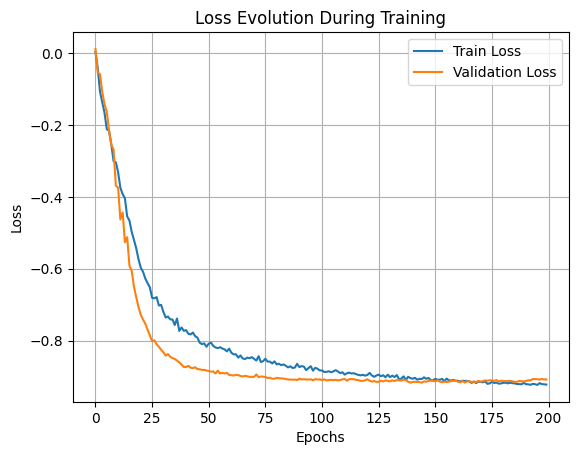

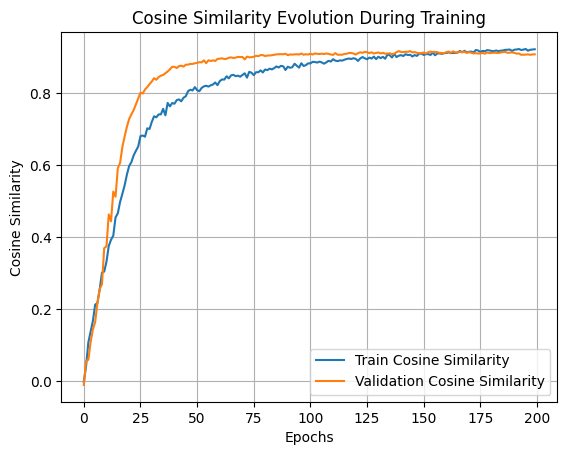

In [ ]:
# Define and train the model as before
print("No existing model found. Training a new model...")

# Define model with Dropout
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)

# Save the trained model
model.save(model_path)
print(f"Model trained and saved as {model_path}")

# Evaluate the model (if loaded or newly trained)
loss, cosine_sim = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Cosine Similarity: {cosine_sim:.4f}")

# Predictions
predictions = model.predict(X_test_scaled)
norms = np.linalg.norm(predictions, axis=1)
print("Mean norm of predicted vectors:", np.mean(norms))
print("Standard deviation of norms:", np.std(norms))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()

# Plot cosine similarity
plt.plot(history.history['cosine_similarity'], label='Train Cosine Similarity')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def convert_cartesian_to_spherical(cartesian_coords):
    """
    Convert Cartesian coordinates to spherical coordinates (RA, DEC).
    """
    x, y, z = cartesian_coords
    r = np.sqrt(x**2 + y**2 + z**2)
    ra = np.arctan2(y, x)
    dec = np.arcsin(z / r)
    ra = np.degrees(ra) % 360  # Convert to degrees and wrap to [0, 360)
    dec = np.degrees(dec)  # Convert to degrees
    return ra, dec

In [34]:
X_scaled = (X - mean_X) / std_X
predictions = model.predict(X_scaled)

RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

import csv
fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [35]:
from gw_grb_correlation.Fermi.util import filtering, duration
# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 357
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.1044229315200459e-06 events per second


In [36]:
from gw_grb_correlation.Fermi.util import read_GW_data, remove_duplicate_times_in_gw_data, compare_time_within_range
# Load GW data
gw_data = read_GW_data(f"./gw_data/totalgwdata.csv")
gw_times = remove_duplicate_times_in_gw_data(gw_data)

# Find matched GRB-GW event pairs
match = compare_time_within_range(short_GRB_data, gw_times, time_range_seconds=86400*3)
filtered_gw_events = gw_data[gw_data['times'].isin(match['gw_time'])]
match.to_csv("GRB_predict_GW_event_pairs.csv", index=False)
filtered_gw_events.to_csv("Filtered_GW_events_with_GRB_prediction.csv", index=False)

Data from ./gw_data/totalgwdata.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418227 entries, 0 to 2418226
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ra          float64
 2   dec         float64
 3   times       float64
 4   weights     float64
dtypes: float64(4), int64(1)
memory usage: 92.2 MB
None
   Unnamed: 0        ra       dec         times   weights
0           0  1.891867 -1.250744  1.126259e+09  0.000024
1           1  1.254342 -1.228042  1.126259e+09  0.000024
2           2  1.666787 -1.279668  1.126259e+09  0.000024
3           3  1.863250 -1.261367  1.126259e+09  0.000024
4           4  0.994238 -1.036272  1.126259e+09  0.000024
Number of unique times after applying threshold: 91
First few unique times:
               times                          date
0       1.126259e+09 2015-09-14 09:51:02.000000000
44173   1.128679e+09 2015-10-12 09:55:00.000000000
79620   1.135136e+09 20

C:\Users\User\Desktop\Theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = pd.to_numeric(fermi_data['TSTART'], errors='coerce')
C:\Users\User\Desktop\Theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = fermi_data['ALIGNED_SEC'] + (fermi_start_date - pd.Timestamp("1980-01-01")).total_seconds()


Found 44 matches within 259200 seconds.


In [37]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,566,987 (13.61 MB)

 Trainable params: 1,188,995 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,377,992 (9.07 MB)

No existing model found. Training a new model...
Epoch 1/200


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - cosine_similarity: -0.0166 - loss: 0.0166 - val_cosine_similarity: 0.0909 - val_loss: -0.0909
Epoch 2/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - cosine_similarity: 0.0606 - loss: -0.0606 - val_cosine_similarity: 0.1170 - val_loss: -0.1170
Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.0919 - loss: -0.0919 - val_cosine_similarity: 0.1437 - val_loss: -0.1437
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.1367 - loss: -0.1367 - val_cosine_similarity: 0.1827 - val_loss: -0.1827
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - cosine_similarity: 0.1771 - loss: -0.1771 - val_cosine_similarity: 0.2083 - val_loss: -0.2083
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.2211 - loss: -0.2211 - val_cosine_similarity: 0.2510 - val_loss: -0.2510
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - cosine_similarity: 0.2224 - loss: -0.2224 - val_cosine_s

Model trained and saved as fermi_direction_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - cosine_similarity: 0.9295 - loss: -0.9295
Test Loss: -0.9242
Cosine Similarity: 0.9242
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean norm of predicted vectors: 0.5418186
Standard deviation of norms: 0.13268186


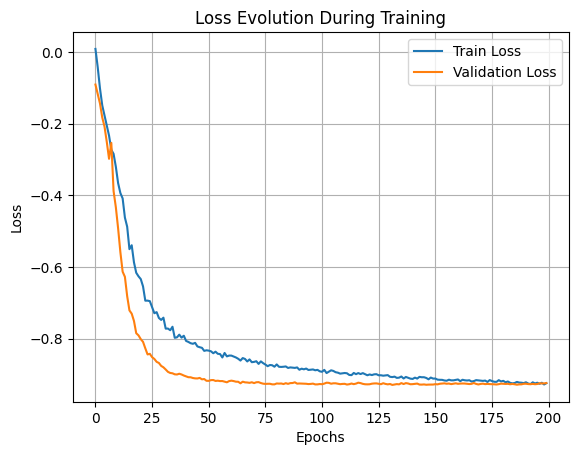

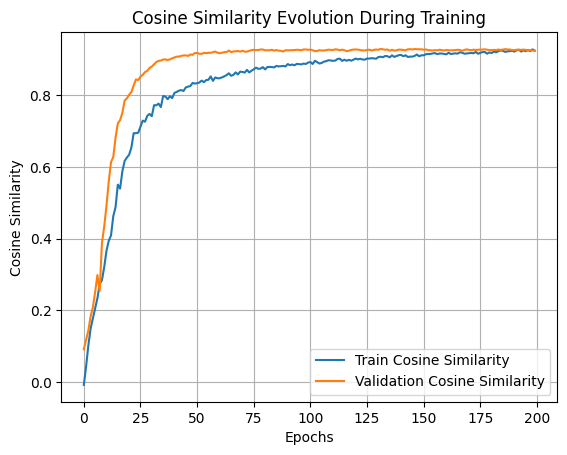

In [38]:
# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

input_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4'] + TRIG_columns

# Extract inputs (X)
X = fermi_data[input_columns].values.astype(np.float64)

# Convert RA and DEC to radians and then to Cartesian unit vectors
ra_rad = np.radians(fermi_data['RA'].values.astype(np.float64))
dec_rad = np.radians(fermi_data['DEC'].values.astype(np.float64))
x = np.cos(dec_rad) * np.cos(ra_rad)
y = np.cos(dec_rad) * np.sin(ra_rad)
z = np.sin(dec_rad)
y = np.stack((x, y, z), axis=-1)

# Clean and split the data
X = np.nan_to_num(X)
y = np.nan_to_num(y)

split_ratio = 0.8
train_size = int(len(X) * split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalize inputs
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
std_X = np.where(std_X == 0, 1, std_X)

X_train_scaled = (X_train - mean_X) / std_X
X_test_scaled = (X_test - mean_X) / std_X
# Define and train the model as before
print("No existing model found. Training a new model...")

# Define model with Dropout
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)

# Save the trained model
model.save(model_path)
print(f"Model trained and saved as {model_path}")

# Evaluate the model (if loaded or newly trained)
loss, cosine_sim = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Cosine Similarity: {cosine_sim:.4f}")

# Predictions
predictions = model.predict(X_test_scaled)
norms = np.linalg.norm(predictions, axis=1)
print("Mean norm of predicted vectors:", np.mean(norms))
print("Standard deviation of norms:", np.std(norms))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()

# Plot cosine similarity
plt.plot(history.history['cosine_similarity'], label='Train Cosine Similarity')
plt.plot(history.history['val_cosine_similarity'], label='Validation Cosine Similarity')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,561,611 (13.59 MB)

 Trainable params: 1,187,203 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,374,408 (9.06 MB)